# Handwritten Digits Recognition Using Shallow Neural Network

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Training data comes from the "MNIST" data set, you can download it from [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).

## Section 1, Data Preparation

In [3]:
data = np.genfromtxt("train.csv", delimiter=',', skip_header=1)
print(data.shape)

(42000, 785)


In [4]:
np.random.shuffle(data)
print(data.shape)
print(data[:10, 0])

(42000, 785)
[7. 9. 4. 7. 1. 2. 9. 4. 9. 7.]


In [5]:
features = data[:, 1:].T
labels = data[:, 0]
labels = np.reshape(labels, (1, -1))
print(features.shape)
print(labels.shape)

(784, 42000)
(1, 42000)


In [6]:
m = features.shape[1]
nx = features.shape[0]
ny = 10

In [7]:
def labels_to_Y(labels):
    Y = np.zeros((ny, m))
    for i in range(m):
        Y[int(labels[0, i]), i] = 1
    return Y

def Y_to_labels(Y):
    labels = np.argmax(Y, axis=0).astype(float)
    labels = np.reshape(labels, (1, -1))
    return labels

def X_to_images(X):
    images = [np.reshape(X[:, i], (28, 28)) for i in range(X.shape[1])]
    return images

(10, 42000)
7.0
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


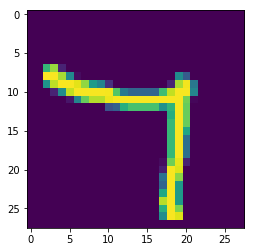

In [8]:
X = features / 255
Y = labels_to_Y(labels)
images = X_to_images(X)
print(Y.shape)
plt.imshow(images[0])
print(labels[0, 0])
print(Y[:, 0])

In [9]:
train_ratio = 0.9

In [10]:
test_ratio = 1 - train_ratio
train_m = int(m * train_ratio)
test_m = m - train_m
train_X = X[:, :train_m]
test_X = X[:, train_m:]
train_Y = Y[:, :train_m]
test_Y = Y[:, train_m:]
train_labels = Y_to_labels(train_Y)
test_labels = Y_to_labels(test_Y)
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)
print(train_labels.shape)

(784, 37800)
(10, 37800)
(784, 4200)
(10, 4200)
(1, 37800)


## Section 2, Design Neural Network

In [11]:
def sigmoid(z):
    a = 1/ (1 + np.exp(-z))
    return a

def sigmoid_prime(z):
    p1 = np.exp(-z)
    a = p1/((1+p1)**2)
    return a

def relu(z):
    a = np.maximum(z, 0.01*z)
    return a

def relu_prime(z):
    a = np.where(z > 0, 1, 0.01)
    return a

def tanh(z):
    p1 = np.exp(z)
    p2 = np.exp(-z)
    a = (p1-p2)/(p1+p2)
    return a
    
def tanh_prime(z):
    p1 = tanh(z)
    a = 1-p1**2
    return a

In [20]:
def loss_function_for__config_multi_layer_classifier_without_regularization(Y_hat, Y):
    delta = 1e-10
    l = -((Y+delta)*np.log(Y_hat+delta) + (1-Y+delta)*np.log(1-Y_hat+delta))
    return l

def forward_propagation_for_config_multi_layer_classifier_without_regularization(model):
    X = model['X']
    Y = model['Y']
    n = model['n']
    L = model['L']
    f = model['f']
    W = model['W']
    b = model['b']
    Z = model['Z']
    A = model['A']
    costs = model['costs']
    loss_function = model['loss_function']
    A[0] = X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    costs.append(np.sum(loss_function(A[L], Y)))

def back_propagation_for_config_multi_layer_classifier_without_regularization(model):
    n = model['n']
    L = model['L']
    f_prime = model['f_prime']
    m = model['m']
    W = model['W']
    Z = model['Z']
    A = model['A']
    Y = model['Y']
    dW = model['dW']
    db = model['db']
    dA = model['dA']
    dZ = model['dZ']
    dZ[L] = A[L] - Y
    dW[L] = np.matmul(dZ[L], A[L-1].T)/m
    db[L] = np.sum(dZ[L], axis=1, keepdims=True)/m
    for i in reversed(range(1, L)):
        dZ[i] = np.matmul(W[i+1].T, dZ[i+1]) * f_prime[i](Z[i])
        dW[i] = np.matmul(dZ[i], A[i-1].T)/m
        db[i] = np.sum(dZ[i], axis=1, keepdims=True)/m
        
def update_for_config_multi_layer_classifier_without_regularization(model):
    L = model['L']
    W = model['W']
    b = model['b']
    dW = model['dW']
    db = model['db']
    learning_rate = model['learning_rate']
    for i in range(1, L+1):
        W[i] -= learning_rate*dW[i]
        b[i] -= learning_rate*db[i]
    
    
def predict_for_config_multi_layer_classifier_without_regularization(model, test_X):
    L = model['L']
    A = model['A']
    Z = model['Z']
    W = model['W']
    b = model['b']
    f = model['f']
    A[0] = test_X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    return A[L]
    
    
def config_multi_layer_classifier_without_regularization(X, Y, neuron_of_hidden_layer, learning_rate):
    n_input_layer = X.shape[0]
    n_output_layer = Y.shape[0]
    
    m = X.shape[1]
    n = [n_input_layer] + neuron_of_hidden_layer + [n_output_layer]
    L = len(n)-1
    f = [tanh if i != 0 else None for i in range(L)]
    f.append(sigmoid)
    f_prime = [tanh_prime if i != 0 else None for i in range(L)]
    f_prime.append(sigmoid_prime)
    W = [np.random.normal(0, 1, (n[i], n[i-1])) if i != 0 else None for i in range(L+1)]
    b = [np.random.normal(0, 1, (n[i], 1)) if i != 0 else None for i in range(L+1)]
    Z = [None for i in range(L+1)]
    A = [None for i in range(L+1)]
    dW = [None for i in range(L+1)]
    db = [None for i in range(L+1)]
    dA = [None for i in range(L+1)]
    dZ = [None for i in range(L+1)]
    costs = []
    
    model = dict()
    model['X'] = X
    model['Y'] = Y
    model['m'] = m
    model['n'] = n
    model['L'] = L
    model['f'] = f
    model['f_prime'] = f_prime
    model['W'] = W
    model['b'] = b
    model['Z'] = Z
    model['A'] = A
    model['dW'] = dW
    model['db'] = db
    model['dA'] = dA
    model['dZ'] = dZ
    model['loss_function'] = loss_function_for__config_multi_layer_classifier_without_regularization
    model['costs'] = costs
    model['learning_rate'] = learning_rate
    model['forwardprop'] = forward_propagation_for_config_multi_layer_classifier_without_regularization
    model['backprop'] = back_propagation_for_config_multi_layer_classifier_without_regularization
    model['update'] = update_for_config_multi_layer_classifier_without_regularization
    model['predict'] = predict_for_config_multi_layer_classifier_without_regularization
    
    return model
        
    

In [25]:
def loss_function_for__config_multi_layer_classifier_with_regularization(model, Y_hat):
    n = model['n']
    Y = model['Y']
    W = model['W']
    L = model['L']
    m = model['m']
    penalty = model['penalty']
    delta = 1e-10
    l = -((Y+delta)*np.log(Y_hat+delta) + (1-Y+delta)*np.log(1-Y_hat+delta))
    p = 0
    for i in range(1, L+1):
        p = p + np.sum(W[i]**2)*penalty/(2*m)
    l = l + p/n[L]
    return l

def forward_propagation_for_config_multi_layer_classifier_with_regularization(model):
    X = model['X']
    Y = model['Y']
    n = model['n']
    L = model['L']
    f = model['f']
    W = model['W']
    b = model['b']
    Z = model['Z']
    A = model['A']
    costs = model['costs']
    loss_function = model['loss_function']
    A[0] = X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    costs.append(np.sum(loss_function(model, A[L])))

def back_propagation_for_config_multi_layer_classifier_with_regularization(model):
    n = model['n']
    L = model['L']
    f_prime = model['f_prime']
    m = model['m']
    W = model['W']
    Z = model['Z']
    A = model['A']
    Y = model['Y']
    penalty = model['penalty']
    dW = model['dW']
    db = model['db']
    dA = model['dA']
    dZ = model['dZ']
    dZ[L] = A[L] - Y
    dW[L] = np.matmul(dZ[L], A[L-1].T)/m
    db[L] = np.sum(dZ[L], axis=1, keepdims=True)/m
    for i in reversed(range(1, L)):
        dZ[i] = np.matmul(W[i+1].T, dZ[i+1]) * f_prime[i](Z[i])
        dW[i] = np.matmul(dZ[i], A[i-1].T)/m + W[i]*penalty/m
        db[i] = np.sum(dZ[i], axis=1, keepdims=True)/m
        
def update_for_config_multi_layer_classifier_with_regularization(model):
    L = model['L']
    W = model['W']
    b = model['b']
    dW = model['dW']
    db = model['db']
    learning_rate = model['learning_rate']
    for i in range(1, L+1):
        W[i] -= learning_rate*dW[i]
        b[i] -= learning_rate*db[i]
    
    
def predict_for_config_multi_layer_classifier_with_regularization(model, test_X):
    L = model['L']
    A = model['A']
    Z = model['Z']
    W = model['W']
    b = model['b']
    f = model['f']
    A[0] = test_X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    return A[L]
    
    
def config_multi_layer_classifier_with_regularization(X, Y, neuron_of_hidden_layer, learning_rate, penalty):
    n_input_layer = X.shape[0]
    n_output_layer = Y.shape[0]
    
    m = X.shape[1]
    n = [n_input_layer] + neuron_of_hidden_layer + [n_output_layer]
    L = len(n)-1
    f = [tanh if i != 0 else None for i in range(L)]
    f.append(sigmoid)
    f_prime = [tanh_prime if i != 0 else None for i in range(L)]
    f_prime.append(sigmoid_prime)
    W = [np.random.normal(0, 1, (n[i], n[i-1])) if i != 0 else None for i in range(L+1)]
    b = [np.random.normal(0, 1, (n[i], 1)) if i != 0 else None for i in range(L+1)]
    Z = [None for i in range(L+1)]
    A = [None for i in range(L+1)]
    dW = [None for i in range(L+1)]
    db = [None for i in range(L+1)]
    dA = [None for i in range(L+1)]
    dZ = [None for i in range(L+1)]
    costs = []
    
    model = dict()
    model['X'] = X
    model['Y'] = Y
    model['m'] = m
    model['n'] = n
    model['L'] = L
    model['f'] = f
    model['f_prime'] = f_prime
    model['W'] = W
    model['b'] = b
    model['Z'] = Z
    model['A'] = A
    model['dW'] = dW
    model['db'] = db
    model['dA'] = dA
    model['dZ'] = dZ
    model['loss_function'] = loss_function_for__config_multi_layer_classifier_with_regularization
    model['costs'] = costs
    model['learning_rate'] = learning_rate
    model['penalty'] = penalty
    model['forwardprop'] = forward_propagation_for_config_multi_layer_classifier_with_regularization
    model['backprop'] = back_propagation_for_config_multi_layer_classifier_with_regularization
    model['update'] = update_for_config_multi_layer_classifier_with_regularization
    model['predict'] = predict_for_config_multi_layer_classifier_with_regularization
    
    return model
        
    

In [22]:
def train_model(iteration_times, model):
    forwardprop = model['forwardprop']
    backprop = model['backprop']
    update = model['update']
    costs = model['costs']
    for i in range(iteration_times):
        forwardprop(model)
        backprop(model)
        update(model)
        print("iteration %d, current loss: %f" % (i, costs[len(costs)-1]))
        

In [27]:
model = config_multi_layer_classifier_with_regularization(train_X, train_Y, [128,32], 1, 1)

iteration 0, current loss: 68945.718264
iteration 1, current loss: 68934.390653
iteration 2, current loss: 68923.083615
iteration 3, current loss: 68911.797592
iteration 4, current loss: 68900.533033
iteration 5, current loss: 68889.290350
iteration 6, current loss: 68878.069885
iteration 7, current loss: 68866.871870
iteration 8, current loss: 68855.696399
iteration 9, current loss: 68844.543415
iteration 10, current loss: 68833.412708
iteration 11, current loss: 68822.303921
iteration 12, current loss: 68811.216569
iteration 13, current loss: 68800.150063
iteration 14, current loss: 68789.103730
iteration 15, current loss: 68778.076840
iteration 16, current loss: 68767.068626
iteration 17, current loss: 68756.078305
iteration 18, current loss: 68745.105089
iteration 19, current loss: 68734.148206
iteration 20, current loss: 68723.206901
iteration 21, current loss: 68712.280454
iteration 22, current loss: 68701.368179
iteration 23, current loss: 68690.469435
iteration 24, current loss

iteration 198, current loss: 66956.089847
iteration 199, current loss: 66946.792440
iteration 200, current loss: 66937.495341
iteration 201, current loss: 66928.199760
iteration 202, current loss: 66918.907134
iteration 203, current loss: 66909.619051
iteration 204, current loss: 66900.337142
iteration 205, current loss: 66891.062967
iteration 206, current loss: 66881.797913
iteration 207, current loss: 66872.543112
iteration 208, current loss: 66863.299397
iteration 209, current loss: 66854.067293
iteration 210, current loss: 66844.847035
iteration 211, current loss: 66835.638617
iteration 212, current loss: 66826.441838
iteration 213, current loss: 66817.256363
iteration 214, current loss: 66808.081767
iteration 215, current loss: 66798.917579
iteration 216, current loss: 66789.763318
iteration 217, current loss: 66780.618515
iteration 218, current loss: 66771.482730
iteration 219, current loss: 66762.355567
iteration 220, current loss: 66753.236681
iteration 221, current loss: 66744

iteration 394, current loss: 65265.599681
iteration 395, current loss: 65257.667324
iteration 396, current loss: 65249.743376
iteration 397, current loss: 65241.827552
iteration 398, current loss: 65233.919551
iteration 399, current loss: 65226.019065
iteration 400, current loss: 65218.125789
iteration 401, current loss: 65210.239419
iteration 402, current loss: 65202.359660
iteration 403, current loss: 65194.486228
iteration 404, current loss: 65186.618860
iteration 405, current loss: 65178.757307
iteration 406, current loss: 65170.901349
iteration 407, current loss: 65163.050790
iteration 408, current loss: 65155.205464
iteration 409, current loss: 65147.365241
iteration 410, current loss: 65139.530025
iteration 411, current loss: 65131.699757
iteration 412, current loss: 65123.874420
iteration 413, current loss: 65116.054038
iteration 414, current loss: 65108.238673
iteration 415, current loss: 65100.428431
iteration 416, current loss: 65092.623456
iteration 417, current loss: 65084

iteration 590, current loss: 63839.459847
iteration 591, current loss: 63832.795557
iteration 592, current loss: 63826.135560
iteration 593, current loss: 63819.479704
iteration 594, current loss: 63812.827834
iteration 595, current loss: 63806.179790
iteration 596, current loss: 63799.535409
iteration 597, current loss: 63792.894524
iteration 598, current loss: 63786.256962
iteration 599, current loss: 63779.622545
iteration 600, current loss: 63772.991090
iteration 601, current loss: 63766.362409
iteration 602, current loss: 63759.736308
iteration 603, current loss: 63753.112586
iteration 604, current loss: 63746.491039
iteration 605, current loss: 63739.871455
iteration 606, current loss: 63733.253619
iteration 607, current loss: 63726.637309
iteration 608, current loss: 63720.022300
iteration 609, current loss: 63713.408363
iteration 610, current loss: 63706.795263
iteration 611, current loss: 63700.182765
iteration 612, current loss: 63693.570630
iteration 613, current loss: 63686

iteration 786, current loss: 62550.757338
iteration 787, current loss: 62544.259068
iteration 788, current loss: 62537.760307
iteration 789, current loss: 62531.260839
iteration 790, current loss: 62524.760433
iteration 791, current loss: 62518.258845
iteration 792, current loss: 62511.755826
iteration 793, current loss: 62505.251128
iteration 794, current loss: 62498.744513
iteration 795, current loss: 62492.235763
iteration 796, current loss: 62485.724693
iteration 797, current loss: 62479.211156
iteration 798, current loss: 62472.695062
iteration 799, current loss: 62466.176378
iteration 800, current loss: 62459.655145
iteration 801, current loss: 62453.131471
iteration 802, current loss: 62446.605539
iteration 803, current loss: 62440.077594
iteration 804, current loss: 62433.547932
iteration 805, current loss: 62427.016885
iteration 806, current loss: 62420.484793
iteration 807, current loss: 62413.951983
iteration 808, current loss: 62407.418737
iteration 809, current loss: 62400

iteration 982, current loss: 61322.804583
iteration 983, current loss: 61316.781138
iteration 984, current loss: 61310.758918
iteration 985, current loss: 61304.737790
iteration 986, current loss: 61298.717639
iteration 987, current loss: 61292.698364
iteration 988, current loss: 61286.679891
iteration 989, current loss: 61280.662172
iteration 990, current loss: 61274.645192
iteration 991, current loss: 61268.628972
iteration 992, current loss: 61262.613572
iteration 993, current loss: 61256.599087
iteration 994, current loss: 61250.585654
iteration 995, current loss: 61244.573442
iteration 996, current loss: 61238.562653
iteration 997, current loss: 61232.553516
iteration 998, current loss: 61226.546283
iteration 999, current loss: 61220.541223
iteration 1000, current loss: 61214.538620
iteration 1001, current loss: 61208.538767
iteration 1002, current loss: 61202.541964
iteration 1003, current loss: 61196.548517
iteration 1004, current loss: 61190.558734
iteration 1005, current loss:

iteration 1173, current loss: 60238.492616
iteration 1174, current loss: 60233.110561
iteration 1175, current loss: 60227.728083
iteration 1176, current loss: 60222.344972
iteration 1177, current loss: 60216.961069
iteration 1178, current loss: 60211.576268
iteration 1179, current loss: 60206.190527
iteration 1180, current loss: 60200.803879
iteration 1181, current loss: 60195.416430
iteration 1182, current loss: 60190.028359
iteration 1183, current loss: 60184.639907
iteration 1184, current loss: 60179.251363
iteration 1185, current loss: 60173.863042
iteration 1186, current loss: 60168.475259
iteration 1187, current loss: 60163.088301
iteration 1188, current loss: 60157.702406
iteration 1189, current loss: 60152.317737
iteration 1190, current loss: 60146.934376
iteration 1191, current loss: 60141.552309
iteration 1192, current loss: 60136.171435
iteration 1193, current loss: 60130.791567
iteration 1194, current loss: 60125.412446
iteration 1195, current loss: 60120.033753
iteration 1

iteration 1364, current loss: 59242.874063
iteration 1365, current loss: 59237.801809
iteration 1366, current loss: 59232.729771
iteration 1367, current loss: 59227.658871
iteration 1368, current loss: 59222.590086
iteration 1369, current loss: 59217.524386
iteration 1370, current loss: 59212.462683
iteration 1371, current loss: 59207.405775
iteration 1372, current loss: 59202.354315
iteration 1373, current loss: 59197.308792
iteration 1374, current loss: 59192.269523
iteration 1375, current loss: 59187.236667
iteration 1376, current loss: 59182.210242
iteration 1377, current loss: 59177.190146
iteration 1378, current loss: 59172.176185
iteration 1379, current loss: 59167.168090
iteration 1380, current loss: 59162.165539
iteration 1381, current loss: 59157.168178
iteration 1382, current loss: 59152.175627
iteration 1383, current loss: 59147.187494
iteration 1384, current loss: 59142.203385
iteration 1385, current loss: 59137.222906
iteration 1386, current loss: 59132.245667
iteration 1

iteration 1555, current loss: 58303.202939
iteration 1556, current loss: 58298.450891
iteration 1557, current loss: 58293.700859
iteration 1558, current loss: 58288.952701
iteration 1559, current loss: 58284.206288
iteration 1560, current loss: 58279.461502
iteration 1561, current loss: 58274.718241
iteration 1562, current loss: 58269.976424
iteration 1563, current loss: 58265.235993
iteration 1564, current loss: 58260.496917
iteration 1565, current loss: 58255.759196
iteration 1566, current loss: 58251.022860
iteration 1567, current loss: 58246.287972
iteration 1568, current loss: 58241.554624
iteration 1569, current loss: 58236.822937
iteration 1570, current loss: 58232.093054
iteration 1571, current loss: 58227.365132
iteration 1572, current loss: 58222.639338
iteration 1573, current loss: 58217.915837
iteration 1574, current loss: 58213.194785
iteration 1575, current loss: 58208.476319
iteration 1576, current loss: 58203.760553
iteration 1577, current loss: 58199.047574
iteration 1

iteration 1746, current loss: 57423.744368
iteration 1747, current loss: 57419.227084
iteration 1748, current loss: 57414.711354
iteration 1749, current loss: 57410.197120
iteration 1750, current loss: 57405.684317
iteration 1751, current loss: 57401.172876
iteration 1752, current loss: 57396.662726
iteration 1753, current loss: 57392.153792
iteration 1754, current loss: 57387.645999
iteration 1755, current loss: 57383.139270
iteration 1756, current loss: 57378.633528
iteration 1757, current loss: 57374.128695
iteration 1758, current loss: 57369.624696
iteration 1759, current loss: 57365.121453
iteration 1760, current loss: 57360.618894
iteration 1761, current loss: 57356.116947
iteration 1762, current loss: 57351.615541
iteration 1763, current loss: 57347.114609
iteration 1764, current loss: 57342.614090
iteration 1765, current loss: 57338.113924
iteration 1766, current loss: 57333.614058
iteration 1767, current loss: 57329.114443
iteration 1768, current loss: 57324.615039
iteration 1

iteration 1937, current loss: 56569.176422
iteration 1938, current loss: 56564.860657
iteration 1939, current loss: 56560.546005
iteration 1940, current loss: 56556.232457
iteration 1941, current loss: 56551.920001
iteration 1942, current loss: 56547.608624
iteration 1943, current loss: 56543.298308
iteration 1944, current loss: 56538.989035
iteration 1945, current loss: 56534.680783
iteration 1946, current loss: 56530.373528
iteration 1947, current loss: 56526.067243
iteration 1948, current loss: 56521.761898
iteration 1949, current loss: 56517.457461
iteration 1950, current loss: 56513.153897
iteration 1951, current loss: 56508.851170
iteration 1952, current loss: 56504.549241
iteration 1953, current loss: 56500.248067
iteration 1954, current loss: 56495.947607
iteration 1955, current loss: 56491.647816
iteration 1956, current loss: 56487.348648
iteration 1957, current loss: 56483.050057
iteration 1958, current loss: 56478.751996
iteration 1959, current loss: 56474.454419
iteration 1

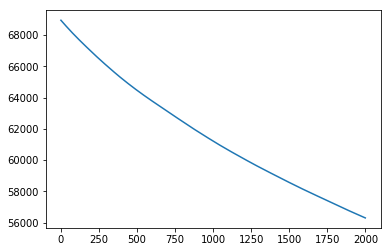

In [32]:
train_model(2000, model)
costs = model['costs']
plt.plot(costs[-2000:])
#print(W[1])

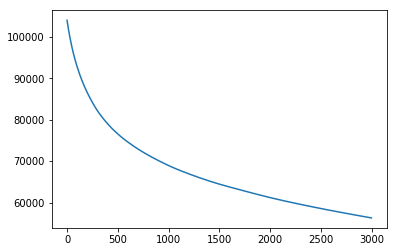

In [33]:
plt.plot(costs[-3000:])

## Section 3, Inspect Performance

In [18]:
def get_accuracy(pred, real):
    right = np.sum(pred==real)
    acc = right/real.shape[1]
    return acc

In [34]:
predict = model['predict']
pred = predict(model, train_X)
pred = Y_to_labels(pred)
acc = get_accuracy(pred, train_labels)
print("training set accuracy: %f" % acc)
pred = predict(model, test_X)
pred = Y_to_labels(pred)
acc = get_accuracy(pred, test_labels)
print("test set accuracy: %f" % acc)

training set accuracy: 0.958413
test set accuracy: 0.881190


In [78]:
np.savez("W-four-layer", *W)
np.savez("b-four-layer", *b)

In [79]:
test_X = np.genfromtxt("test.csv", delimiter=',', skip_header=1)
test_X = test_X.T
test_X = test_X/255
print(test_X.shape)

(784, 28000)


In [80]:
test_Y = predict(test_X)
test_labels = Y_to_labels(test_Y)
print(test_labels.shape)

(1, 28000)


In [81]:
output = np.zeros((test_labels.shape[1], 2), dtype=int)
for i in range(output.shape[0]):
    output[i, 0] = i+1
    output[i, 1] = test_labels[0, i]

In [82]:
np.savetxt("4layer-submission.csv", output, fmt="%d", delimiter=',', header='ImageId,Label')

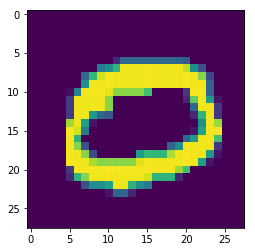

In [83]:
test_images = X_to_images(test_X)
plt.imshow(test_images[1])